In [1]:
import pandas as pd
from DataGen import DataGen

D = DataGen()
D.test_data

,Word,Size,Length,Frequency,Zipf Frequency,Morph Complexity,Lexicality,Part of Speech,Phonemes
0,bathmat,long,7,low,1.55,complex,real,NOUN,"[B, AE1, TH, M, AH0, T]"
1,decoder,long,7,low,2.84,complex,real,NOUN,"[D, IH0, K, OW1, D, ER0]"
2,defiant,long,7,low,3.21,complex,real,ADJ,"[D, IH0, F, AY1, AH0, N, T]"
3,padlock,long,7,low,2.68,complex,real,NOUN,"[P, AE1, D, L, AA2, K]"
4,immoral,long,7,low,3.46,complex,real,ADJ,"[IH0, M, AO1, R, AH0, L]"
...,...,...,...,...,...,...,...,...,...
340,unrich,short,6,NaN,NaN,complex,pseudo,NaN,"[AH1, N, R, IH0, CH]"
341,upholt,short,6,NaN,NaN,complex,pseudo,NaN,"[AH0, P, OW1, L, T]"
342,warels,short,6,NaN,NaN,complex,pseudo,NaN,"[W, EH1, R, AH0, L, Z]"
343,wately,short,6,NaN,NaN,complex,pseudo,NaN,"[W, EY1, T, L, IY0]"


3_2_1_0.0_0.005
Epoch 1: T Loss: 1.3423 V Loss: 0.8154 Time: 228.69s
Epoch 2: T Loss: 0.6864 V Loss: 0.5256 Time: 225.32s
Epoch 3: T Loss: 0.4688 V Loss: 0.3536 Time: 227.58s


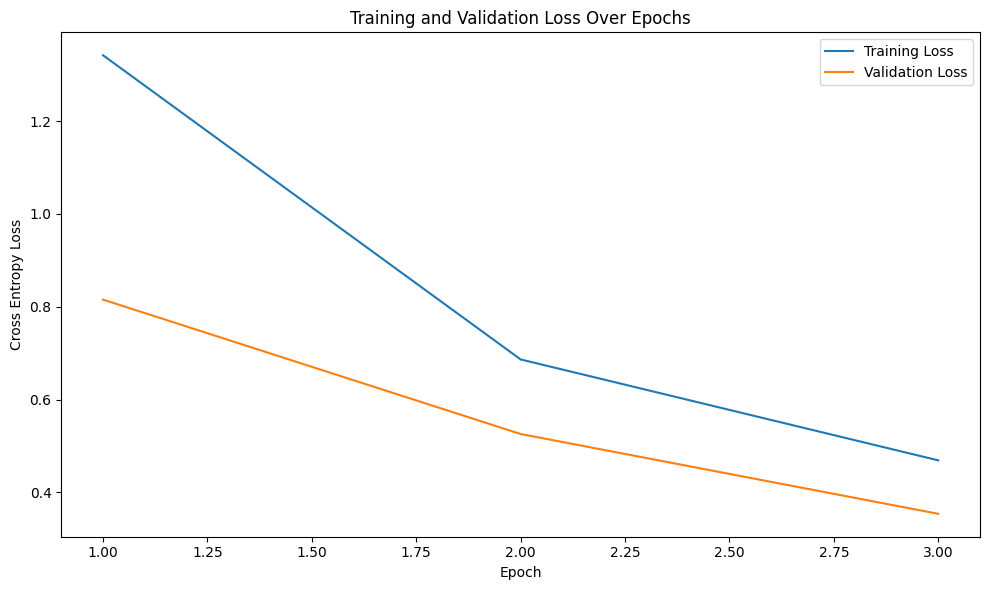

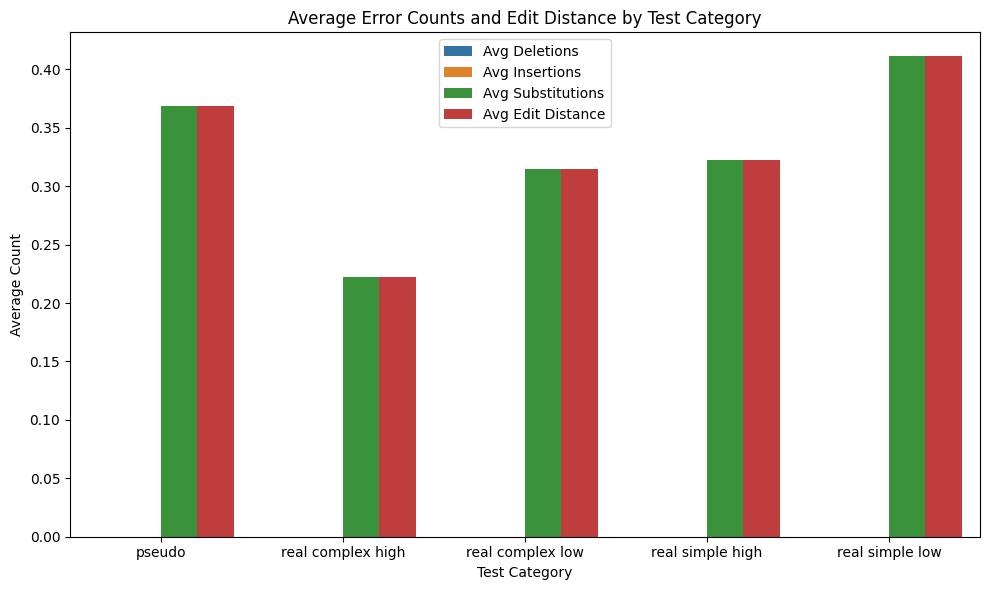


Timing Summary:
------------------------------------------------------------
Operation                      Total Time (s)  Avg Time (s)   
------------------------------------------------------------
Encoder Forward Pass                  51.172s         0.000s
Decoder Forward Pass                  34.992s         0.000s
Backward Pass                        445.698s         0.003s
Validation                            32.568s        10.856s
Testing                                2.761s         2.761s


In [3]:
from train_repetition import train_repetition

eval_data = train_repetition(D, hidden_size=2)

In [3]:
pd.set_option('display.max_rows', 2000)
eval_data

,Word,Length,Frequency,Zipf Frequency,Morph Complexity,Lexicality,Part of Speech,Phonemes,Prediction,Deletions,Insertions,Substitutions,Edit Distance,Category
0,bathmat,7,low,1.55,complex,real,NOUN,"[B, AE1, TH, M, AH0, T]","[B, AE1, TH, M, AH0, T]",0,0,0,0,real complex low
1,decoder,7,low,2.84,complex,real,NOUN,"[D, IH0, K, OW1, D, ER0]","[D, IH0, K, OW1, D, ER0]",0,0,0,0,real complex low
2,defiant,7,low,3.21,complex,real,ADJ,"[D, IH0, F, AY1, AH0, N, T]","[D, IH0, F, AY1, AH0, N, T]",0,0,0,0,real complex low
3,padlock,7,low,2.68,complex,real,NOUN,"[P, AE1, D, L, AA2, K]","[P, AE1, D, L, AA2, K]",0,0,0,0,real complex low
4,immoral,7,low,3.46,complex,real,ADJ,"[IH0, M, AO1, R, AH0, L]","[IH0, M, AO1, R, AH0, L]",0,0,0,0,real complex low
5,nonstop,7,low,3.37,complex,real,ADJ,"[N, AA2, N, S, T, AA1, P]","[N, AA2, N, S, T, AA1, P]",0,0,0,0,real complex low
6,parasol,7,low,2.63,complex,real,PROPN,"[P, EH1, R, AH0, S, AO2, L]","[P, EH1, R, AH0, S, AO2, L]",0,0,0,0,real complex low
7,reactor,7,low,3.83,complex,real,NOUN,"[R, IY0, AE1, K, T, ER0]","[R, IY0, AE1, K, T, ER0]",0,0,0,0,real complex low
8,recycle,7,low,3.35,complex,real,NOUN,"[R, IY0, S, AY1, K, AH0, L]","[R, IY0, S, AY1, K, AH0, L]",0,0,0,0,real complex low
9,reenact,7,low,2.42,complex,real,VERB,"[R, IY0, IH0, N, AE1, K, T]","[R, IY0, IH0, N, AE1, K, T]",0,0,0,0,real complex low
